In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from cadet_imports import *

import my_cadet_utils as cad_utils
import parameter_correlations as corr
import exploration_helper as explor

import multiprocessing as mp
import gc

from scipy import interpolate
from scipy import optimize
import time

# Set up fixed parameters

Keq range and correlated Ds

In [4]:
resin  = 'phq'
keq_fit_params, Ds_fit_params = corr.get_correlation(resin)
Ds_fit_params = np.array(Ds_fit_params)

Ds_fit_params

/home/chase/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


array([[ 7.54087735e-12, -1.01787058e+00],
       [ 1.10039498e-11, -1.89305438e+00],
       [ 4.73345747e-12, -1.70831914e+00],
       [ 7.71250986e-12, -4.35260843e+00]])

In [5]:
a = np.mean(np.array([Ds_fit_params[i, 0] for i in range(3)]))
b = np.mean(np.array([Ds_fit_params[i, 1] for i in range(3)]))
print(a, b)

7.759428219587115e-12 -1.539748035729174


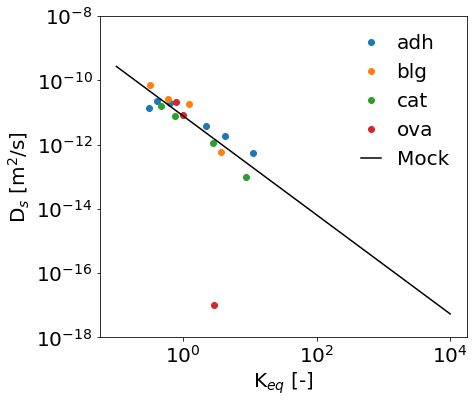

In [7]:
keq_vals = np.logspace(-1, 4, 3)
ds_vals  = np.array([explor.get_ds(keq, a, b) for keq in keq_vals])

fig, ax = plt.subplots()
corr.plot_ds(resin, fig, ax)

ax.plot(keq_vals, ds_vals, color='black', label='Mock')
ax.legend(loc='best', frameon=False, handlelength=1.0)
explor.set_layout(fig, ax)
fig.savefig('./images_relevant_variable/previous_Ds_correlation.png', dpi=200)

# Simulations
## Run these always

In [6]:
results_folder = Path().absolute() / 'sim_results_relevant_variable'
if not os.path.exists( results_folder.as_posix() ):
    os.makedirs( results_folder.as_posix() )
    
image_folder = Path().absolute() / 'images_relevant_variable'
if not os.path.exists( image_folder.as_posix() ):
    os.makedirs( image_folder.as_posix() )

In [7]:
keq = 1000.0
Ds = explor.get_ds(keq, a, b)

eps_c = 0.49
eps_p = 0.4
eps_t = eps_c + eps_p*(1.0 - eps_c)

mass       = 50
cap_mg     = 100 # [mg/ml column]
q_m_fac    = cap_mg/(1.0-eps_t)
q_max      = q_m_fac/mass # [mol m-3 resin]

c_load = 2.0e-5

d_col = 0.5e-2
area_col = np.pi/4 * d_col**2

In [8]:
fVolum_vals = np.linspace(1.633e-9, 1.633e-8, 4) # for d_c = 0.5 cm, corresponds to 30-300 cm/h
Dp_vals     = np.linspace(2.0e-12, 4.0e-11, 4)
d_part_vals = np.linspace(5.0e-6, 200.0e-6, 4)
l_col_vals  = np.linspace(5.0e-2, 50.0e-2, 4)


In [9]:
def local_run_sim_fun(args):
    sim, res_file = args
    print(res_file[res_file.rfind('/'):])
    
    run_time = time.time()
    cad_utils.run_simulation(sim, res_file)
    rtime = (time.time()-run_time)/60.0
    return

def solve_time(time, frac, f):
    return f(time) - frac

def get_sim_data(file_name):               
    c_load, c_out, t, fVolum, Dp, d_part, l_col =\
    explor.get_sim_results_more_general(results_folder, file_name)

    d_col = 0.5e-2
    area_col = np.pi/4 * d_col**2
    v_col = area_col * l_col
    norm_c = c_out/c_load
    f = interpolate.interp1d(t, norm_c, kind='cubic')

    these_res = [fVolum, Dp, d_part, l_col]
    fracs = np.arange(0.01, 0.8, 0.01)

    for frac in fracs:
        idx = np.searchsorted(norm_c, frac, side="left")
        t_guess = t[idx]
        ftime = optimize.fsolve(solve_time, t_guess, args=(frac, f))[0]
        v_break  = ftime * fVolum
        cv_break = v_break/v_col
        fun_pe   = (cv_break - eps_c)/keq
        these_res.append(fun_pe)
    print(file_name)
    return these_res

### Run

In [10]:
## With multiprocessing
args_list = []

for fVolum in fVolum_vals:
    for Dp in Dp_vals:
        for d_part in d_part_vals:
            for l_col in l_col_vals:
                file_name = f'Q_{fVolum:.1e}_Dp_{Dp:.1e}_dpart_{d_part:.1e}_lcol_{l_col:.1e}.h5'
                res_file = os.path.join(results_folder, file_name)

                V_col = np.pi/4 * (0.5**2) * 1e-4 * l_col # [m3]
                t_max = 4.5*V_col/fVolum*(keq*(1-eps_t) + eps_t) + 5000
                ka    = explor.get_ka(keq, q_max)

                sim = cad_utils.get_more_general_system(load_c=c_load, 
                        Dp=Dp, Ds=Ds, q_max=q_max, ka=ka, t_max=t_max,
                        use_linear=False, fVolumetric=fVolum, d_part=d_part,
                        l_col=l_col)

                args = (sim, res_file)
                args_list.append(args)

In [50]:
pool      = mp.Pool(processes = mp.cpu_count())
results   = pool.map(local_run_sim_fun, args_list)
pool.close()
pool.join()

/Q_1.6e-09_Dp_2.0e-12_dpart_5.0e-06_lcol_5.0e-02.h5
/Q_1.6e-09_Dp_2.0e-12_dpart_7.0e-05_lcol_5.0e-02.h5
/Q_1.6e-09_Dp_2.0e-12_dpart_5.0e-06_lcol_3.5e-01.h5
/Q_1.6e-09_Dp_2.0e-12_dpart_7.0e-05_lcol_3.5e-01.h5
/Q_1.6e-09_Dp_2.0e-12_dpart_1.4e-04_lcol_5.0e-02.h5
/Q_1.6e-09_Dp_2.0e-12_dpart_1.4e-04_lcol_3.5e-01.h5
/Q_1.6e-09_Dp_2.0e-12_dpart_2.0e-04_lcol_5.0e-02.h5
/Q_1.6e-09_Dp_2.0e-12_dpart_2.0e-04_lcol_3.5e-01.h5
/Q_1.6e-09_Dp_1.5e-11_dpart_5.0e-06_lcol_5.0e-02.h5
/Q_1.6e-09_Dp_1.5e-11_dpart_5.0e-06_lcol_3.5e-01.h5
/Q_1.6e-09_Dp_1.5e-11_dpart_7.0e-05_lcol_5.0e-02.h5
/Q_1.6e-09_Dp_1.5e-11_dpart_7.0e-05_lcol_3.5e-01.h5/Q_1.6e-09_Dp_1.5e-11_dpart_1.4e-04_lcol_5.0e-02.h5

/Q_1.6e-09_Dp_1.5e-11_dpart_1.4e-04_lcol_3.5e-01.h5
/Q_1.6e-09_Dp_1.5e-11_dpart_2.0e-04_lcol_5.0e-02.h5
/Q_1.6e-09_Dp_1.5e-11_dpart_2.0e-04_lcol_3.5e-01.h5
/Q_1.6e-09_Dp_2.7e-11_dpart_5.0e-06_lcol_5.0e-02.h5
/Q_1.6e-09_Dp_2.7e-11_dpart_7.0e-05_lcol_5.0e-02.h5
/Q_1.6e-09_Dp_2.7e-11_dpart_5.0e-06_lcol_3.5e-01.h5
/Q_1.6e-09_D

/Q_1.6e-08_Dp_2.0e-12_dpart_5.0e-06_lcol_5.0e-01.h5
Simulation completed successfully
/Q_1.6e-08_Dp_1.5e-11_dpart_5.0e-06_lcol_5.0e-02.h5
Simulation completed successfully
Simulation completed successfully
/Q_1.6e-08_Dp_1.5e-11_dpart_5.0e-06_lcol_3.5e-01.h5/Q_1.6e-08_Dp_1.5e-11_dpart_7.0e-05_lcol_5.0e-02.h5

Simulation completed successfully
/Q_1.6e-08_Dp_1.5e-11_dpart_7.0e-05_lcol_3.5e-01.h5
Simulation completed successfully
/Q_1.6e-08_Dp_1.5e-11_dpart_1.4e-04_lcol_5.0e-02.h5
Simulation completed successfully
/Q_1.6e-08_Dp_1.5e-11_dpart_5.0e-06_lcol_2.0e-01.h5
Simulation completed successfully
/Q_1.6e-08_Dp_1.5e-11_dpart_1.4e-04_lcol_3.5e-01.h5
Simulation completed successfully
/Q_1.1e-08_Dp_4.0e-11_dpart_1.4e-04_lcol_5.0e-01.h5
Simulation completed successfully
/Q_1.6e-08_Dp_1.5e-11_dpart_7.0e-05_lcol_2.0e-01.h5
Simulation completed successfully
/Q_1.6e-08_Dp_2.0e-12_dpart_7.0e-05_lcol_5.0e-01.h5
Simulation completed successfully
/Q_1.6e-08_Dp_1.5e-11_dpart_1.4e-04_lcol_2.0e-01.h5
Si

### Get data

In [13]:
files = []

for fVolum in fVolum_vals:
    for Dp in Dp_vals:
        for d_part in d_part_vals:
            for l_col in l_col_vals:
                file_name = f'Q_{fVolum:.1e}_Dp_{Dp:.1e}_dpart_{d_part:.1e}_lcol_{l_col:.1e}.h5'
                files.append(file_name)

pool      = mp.Pool(processes = 10)
results   = pool.map(get_sim_data, files)
pool.close()
pool.join()

Q_1.6e-09_Dp_2.0e-12_dpart_5.0e-06_lcol_5.0e-02.h5
Q_1.6e-09_Dp_1.5e-11_dpart_2.0e-04_lcol_5.0e-02.h5
Q_1.6e-09_Dp_4.0e-11_dpart_1.4e-04_lcol_5.0e-02.h5
Q_1.6e-09_Dp_4.0e-11_dpart_5.0e-06_lcol_2.0e-01.h5
Q_1.6e-09_Dp_1.5e-11_dpart_7.0e-05_lcol_2.0e-01.h5
Q_1.6e-09_Dp_4.0e-11_dpart_1.4e-04_lcol_2.0e-01.h5
Q_1.6e-09_Dp_1.5e-11_dpart_2.0e-04_lcol_2.0e-01.h5
Q_1.6e-09_Dp_2.0e-12_dpart_5.0e-06_lcol_2.0e-01.h5
Q_1.6e-09_Dp_2.0e-12_dpart_2.0e-04_lcol_3.5e-01.h5
Q_1.6e-09_Dp_2.7e-11_dpart_1.4e-04_lcol_3.5e-01.h5
Q_1.6e-09_Dp_4.0e-11_dpart_2.0e-04_lcol_5.0e-01.h5
Q_1.6e-09_Dp_2.0e-12_dpart_7.0e-05_lcol_5.0e-01.h5
Q_1.6e-09_Dp_4.0e-11_dpart_5.0e-06_lcol_3.5e-01.h5
Q_1.6e-09_Dp_1.5e-11_dpart_7.0e-05_lcol_3.5e-01.h5
Q_6.5e-09_Dp_2.0e-12_dpart_5.0e-06_lcol_5.0e-02.h5
Q_1.6e-09_Dp_2.0e-12_dpart_1.4e-04_lcol_5.0e-02.h5
Q_1.6e-09_Dp_2.7e-11_dpart_5.0e-06_lcol_5.0e-01.h5
Q_6.5e-09_Dp_2.0e-12_dpart_5.0e-06_lcol_2.0e-01.h5
Q_1.6e-09_Dp_2.0e-12_dpart_5.0e-06_lcol_3.5e-01.h5
Q_1.6e-09_Dp_1.5e-11_dpart_2.0e

In [15]:
d_col = 0.5e-2
area_col = np.pi/4 * d_col**2
fracs = np.arange(0.01, 0.8, 0.01)

columns = ['fVolum', 'Dp', 'd_part', 'l_col'] + [f'{i:.2f}' for i in fracs]
df = pd.DataFrame(results, columns=columns)
df['v'] = df['fVolum']/(eps_c * area_col)
df['pe'] = df['v'] * df['d_part'] / df['Dp']
df['yam_x'] = df['pe'] * df['d_part'] / df['l_col']

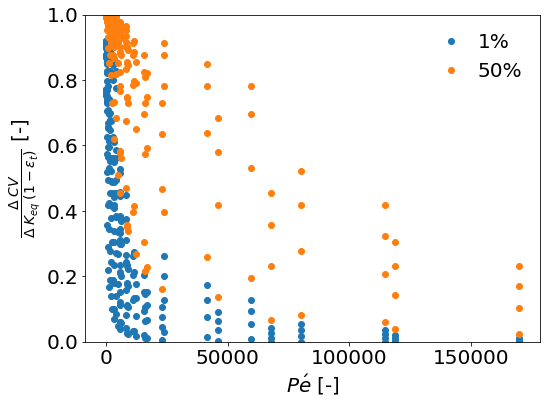

In [17]:
fig, ax = explor.instantiate_fig(8, 6)
ax.set_ylabel(r'$\frac{\Delta \; CV}{\Delta \; K_{eq} \; (1 - \epsilon_t)}$ [-]')
ax.set_xlabel(r'$P\'{e}$ [-]')

ax.plot(df['pe'], df['0.01']/(1.0-eps_t), 'o', label='1%')
ax.plot(df['pe'], df['0.50']/(1.0-eps_t), 'o', label='50%')

ax.set_ylim(0, 1)
explor.set_layout(fig, ax, legend=True)
fig.savefig((image_folder / 'pe.png').as_posix(), dpi=300)

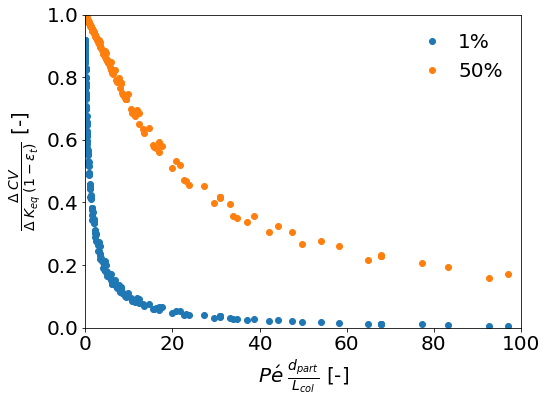

In [149]:
fig, ax = explor.instantiate_fig(8, 6)
ax.set_ylabel(r'$\frac{\Delta \; CV}{\Delta \; K_{eq} \; (1 - \epsilon_t)}$ [-]')
ax.set_xlabel(r'$P\'{e} \; \frac{d_{part}}{L_{col}}$ [-]')
ax.plot(df['yam_x'], df['0.01']/(1.0-eps_t), 'o', label='1%')
ax.plot(df['yam_x'], df['0.50']/(1.0-eps_t), 'o', label='50%')

ax.set_xlim(0, 100)
ax.set_ylim(0, 1)
explor.set_layout(fig, ax, legend=True)
fig.savefig((image_folder / 'yam_x.png').as_posix(), dpi=300)

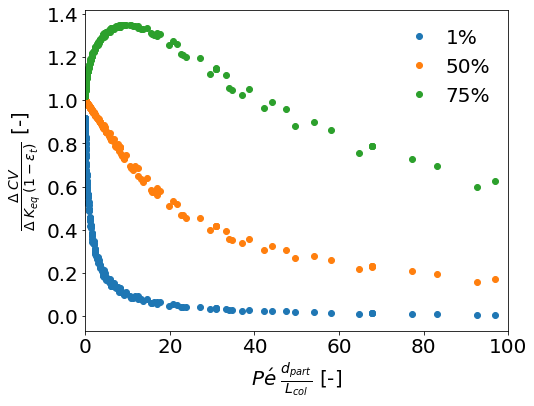

In [223]:
fig, ax = explor.instantiate_fig(8, 6)
ax.set_ylabel(r'$\frac{\Delta \; CV}{\Delta \; K_{eq} \; (1 - \epsilon_t)}$ [-]')
ax.set_xlabel(r'$P\'{e} \; \frac{d_{part}}{L_{col}}$ [-]')

ax.plot(df['yam_x'], df['0.01']/(1.0-eps_t), 'o', label='1%')
ax.plot(df['yam_x'], df['0.50']/(1.0-eps_t), 'o', label='50%')
ax.plot(df['yam_x'], df['0.75']/(1.0-eps_t), 'o', label='75%')


ax.set_xlim(0, 100)
# ax.set_ylim(0, 1)
explor.set_layout(fig, ax, legend=True)
fig.savefig((image_folder / 'yam_x_later_breakthrough.png').as_posix(), dpi=300)

In [77]:
def as_si(x, ndp):
    s = '{x:0.{ndp:d}e}'.format(x=x, ndp=ndp)
    m, e = s.split('e')
    return r'{m:s}\times 10^{{{e:d}}}'.format(m=m, e=int(e))

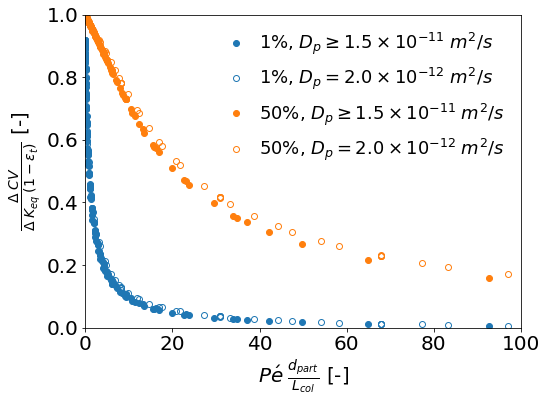

In [153]:
fig, ax = explor.instantiate_fig(8, 6)
ax.set_ylabel(r'$\frac{\Delta \; CV}{\Delta \; K_{eq} \; (1 - \epsilon_t)}$ [-]')
ax.set_xlabel(r'$P\'{e} \; \frac{d_{part}}{L_{col}}$ [-]')

df_smooth = df[df.Dp != 2e-12]
df_high = df[df.Dp == 2e-12]

ax.plot(df_smooth['yam_x'], df_smooth['0.01']/(1.0-eps_t), 'o', 
        label=fr'1%, $D_p \geq {as_si(Dp_vals[1], 1):s} \; m^2/s$')
ax.plot(df_high['yam_x'], df_high['0.01']/(1.0-eps_t), 'o', 
        mfc='none', color=plt.gca().lines[-1].get_color(),
        label=fr'1%, $D_p = {as_si(Dp_vals[0], 1):s} \; m^2/s$')

ax.plot(df_smooth['yam_x'], df_smooth['0.50']/(1.0-eps_t), 'o',
       label=fr'50%, $D_p \geq {as_si(Dp_vals[1], 1):s} \; m^2/s$')
ax.plot(df_high['yam_x'], df_high['0.50']/(1.0-eps_t), 'o', 
        mfc='none', color=plt.gca().lines[-1].get_color(),
       label=fr'50%, $D_p = {as_si(Dp_vals[0], 1):s} \; m^2/s$')


ax.set_xlim(0, 100)
ax.set_ylim(0, 1)
explor.set_layout(fig, ax, legend=True, fontsize=18)
fig.savefig((image_folder / 'yam_x_Dp_distinction.png').as_posix(), dpi=300)

## Compare with lower Keq
### And check that higher Dp remain on the smooth correlation line (confirmed)

In [25]:
results_folder = Path().absolute() / 'sim_results_relevant_variable_keq_check'
if not os.path.exists( results_folder.as_posix() ):
    os.makedirs( results_folder.as_posix() )

In [26]:
keq = 100.0
Ds = explor.get_ds(keq, a, b)

eps_c = 0.49
eps_p = 0.4
eps_t = eps_c + eps_p*(1.0 - eps_c)

mass       = 50
cap_mg     = 100 # [mg/ml column]
q_m_fac    = cap_mg/(1.0-eps_t)
q_max      = q_m_fac/mass # [mol m-3 resin]

c_load = 2.0e-5

In [29]:
fVolum_vals = np.linspace(1.633e-9, 1.633e-8, 4) # for d_c = 0.5 cm, corresponds to 30-300 cm/h
# Dp_vals     = np.linspace(5.0e-11, 1.0e-10, 2)
# Dp_vals     = np.linspace(2.0e-12, 4.0e-11, 4)
Dp_vals     = np.array([2.0e-12])
d_part_vals = np.linspace(5.0e-6, 200.0e-6, 4)
l_col_vals  = np.linspace(5.0e-2, 50.0e-2, 4)


### Run

In [30]:
## With multiprocessing
args_list = []

for fVolum in fVolum_vals:
    for Dp in Dp_vals:
        for d_part in d_part_vals:
            for l_col in l_col_vals:
                file_name = f'Q_{fVolum:.1e}_Dp_{Dp:.1e}_dpart_{d_part:.1e}_lcol_{l_col:.1e}_desc_2.h5'
                res_file = os.path.join(results_folder, file_name)

                V_col = np.pi/4 * (0.5**2) * 1e-4 * l_col # [m3]
                t_max = 4.5*V_col/fVolum*(keq*(1-eps_t) + eps_t) + 5000
                ka    = explor.get_ka(keq, q_max)

                sim = cad_utils.get_more_general_system(load_c=c_load, 
                        Dp=Dp, Ds=Ds, q_max=q_max, ka=ka, t_max=t_max,
                        use_linear=False, fVolumetric=fVolum, d_part=d_part,
                        l_col=l_col)

                args = (sim, res_file)
                args_list.append(args)

In [31]:
pool      = mp.Pool(processes = mp.cpu_count())
results   = pool.map(local_run_sim_fun, args_list)
pool.close()
pool.join()

/Q_1.6e-09_Dp_2.0e-12_dpart_5.0e-06_lcol_5.0e-02_desc_2.h5/Q_1.6e-09_Dp_2.0e-12_dpart_5.0e-06_lcol_2.0e-01_desc_2.h5

/Q_1.6e-09_Dp_2.0e-12_dpart_5.0e-06_lcol_3.5e-01_desc_2.h5
/Q_1.6e-09_Dp_2.0e-12_dpart_7.0e-05_lcol_5.0e-02_desc_2.h5
/Q_1.6e-09_Dp_2.0e-12_dpart_7.0e-05_lcol_2.0e-01_desc_2.h5/Q_1.6e-09_Dp_2.0e-12_dpart_5.0e-06_lcol_5.0e-01_desc_2.h5

/Q_1.6e-09_Dp_2.0e-12_dpart_7.0e-05_lcol_3.5e-01_desc_2.h5
/Q_1.6e-09_Dp_2.0e-12_dpart_1.4e-04_lcol_5.0e-02_desc_2.h5
/Q_1.6e-09_Dp_2.0e-12_dpart_7.0e-05_lcol_5.0e-01_desc_2.h5/Q_1.6e-09_Dp_2.0e-12_dpart_1.4e-04_lcol_2.0e-01_desc_2.h5

/Q_1.6e-09_Dp_2.0e-12_dpart_1.4e-04_lcol_3.5e-01_desc_2.h5
/Q_1.6e-09_Dp_2.0e-12_dpart_2.0e-04_lcol_5.0e-02_desc_2.h5
/Q_1.6e-09_Dp_2.0e-12_dpart_1.4e-04_lcol_5.0e-01_desc_2.h5/Q_1.6e-09_Dp_2.0e-12_dpart_2.0e-04_lcol_2.0e-01_desc_2.h5

/Q_1.6e-09_Dp_2.0e-12_dpart_2.0e-04_lcol_3.5e-01_desc_2.h5
/Q_1.6e-09_Dp_2.0e-12_dpart_2.0e-04_lcol_5.0e-01_desc_2.h5/Q_6.5e-09_Dp_2.0e-12_dpart_5.0e-06_lcol_5.0e-02_desc_2.h

OSError: Unable to open file (bad object header version number)

### Get data

In [32]:
Dp_vals = np.append(np.linspace(2.0e-12, 4.0e-11, 4), np.linspace(5.0e-11, 1.0e-10, 2))
Dp_vals

array([2.00000000e-12, 1.46666667e-11, 2.73333333e-11, 4.00000000e-11,
       5.00000000e-11, 1.00000000e-10])

In [21]:
files = []

for fVolum in fVolum_vals:
    for Dp in Dp_vals:
        for d_part in d_part_vals:
            for l_col in l_col_vals:
                file_name = f'Q_{fVolum:.1e}_Dp_{Dp:.1e}_dpart_{d_part:.1e}_lcol_{l_col:.1e}.h5'
                files.append(file_name)
                    
pool      = mp.Pool(processes = 5)
results   = pool.map(get_sim_data, files)
pool.close()
pool.join()

Q_1.6e-09_Dp_2.7e-11_dpart_1.4e-04_lcol_5.0e-02.h5Q_1.6e-09_Dp_1.0e-10_dpart_5.0e-06_lcol_5.0e-02.h5

Q_1.6e-09_Dp_2.0e-12_dpart_5.0e-06_lcol_5.0e-02.h5Q_1.6e-09_Dp_4.0e-11_dpart_2.0e-04_lcol_5.0e-02.h5

Q_1.6e-09_Dp_1.5e-11_dpart_7.0e-05_lcol_5.0e-02.h5
Q_1.6e-09_Dp_2.7e-11_dpart_1.4e-04_lcol_2.0e-01.h5
Q_1.6e-09_Dp_4.0e-11_dpart_2.0e-04_lcol_2.0e-01.h5
Q_1.6e-09_Dp_1.0e-10_dpart_5.0e-06_lcol_2.0e-01.h5
Q_1.6e-09_Dp_1.5e-11_dpart_7.0e-05_lcol_2.0e-01.h5
Q_1.6e-09_Dp_2.0e-12_dpart_5.0e-06_lcol_2.0e-01.h5
Q_1.6e-09_Dp_2.7e-11_dpart_1.4e-04_lcol_3.5e-01.h5
Q_1.6e-09_Dp_4.0e-11_dpart_2.0e-04_lcol_3.5e-01.h5
Q_1.6e-09_Dp_1.0e-10_dpart_5.0e-06_lcol_3.5e-01.h5
Q_1.6e-09_Dp_1.5e-11_dpart_7.0e-05_lcol_3.5e-01.h5
Q_1.6e-09_Dp_2.0e-12_dpart_5.0e-06_lcol_3.5e-01.h5
Q_1.6e-09_Dp_4.0e-11_dpart_2.0e-04_lcol_5.0e-01.h5
Q_1.6e-09_Dp_1.0e-10_dpart_5.0e-06_lcol_5.0e-01.h5
Q_1.6e-09_Dp_2.7e-11_dpart_1.4e-04_lcol_5.0e-01.h5
Q_1.6e-09_Dp_1.5e-11_dpart_7.0e-05_lcol_5.0e-01.h5
Q_1.6e-09_Dp_2.0e-12_dpart_5.0e

Q_1.6e-08_Dp_4.0e-11_dpart_7.0e-05_lcol_3.5e-01.h5
Q_1.6e-08_Dp_2.7e-11_dpart_5.0e-06_lcol_5.0e-01.h5
Q_1.6e-08_Dp_5.0e-11_dpart_1.4e-04_lcol_3.5e-01.h5
Q_1.6e-08_Dp_1.5e-11_dpart_7.0e-05_lcol_5.0e-01.h5
Q_1.6e-08_Dp_1.0e-10_dpart_2.0e-04_lcol_3.5e-01.h5
Q_1.6e-08_Dp_4.0e-11_dpart_7.0e-05_lcol_5.0e-01.h5
Q_1.6e-08_Dp_2.7e-11_dpart_7.0e-05_lcol_5.0e-02.h5
Q_1.6e-08_Dp_1.5e-11_dpart_1.4e-04_lcol_5.0e-02.h5
Q_1.6e-08_Dp_5.0e-11_dpart_1.4e-04_lcol_5.0e-01.h5
Q_1.6e-08_Dp_4.0e-11_dpart_1.4e-04_lcol_5.0e-02.h5
Q_1.6e-08_Dp_2.7e-11_dpart_7.0e-05_lcol_2.0e-01.h5
Q_1.6e-08_Dp_5.0e-11_dpart_2.0e-04_lcol_5.0e-02.h5
Q_1.6e-08_Dp_1.5e-11_dpart_1.4e-04_lcol_2.0e-01.h5
Q_1.6e-08_Dp_1.0e-10_dpart_2.0e-04_lcol_5.0e-01.h5
Q_1.6e-08_Dp_4.0e-11_dpart_1.4e-04_lcol_2.0e-01.h5
Q_1.6e-08_Dp_2.7e-11_dpart_7.0e-05_lcol_3.5e-01.h5
Q_1.6e-08_Dp_1.5e-11_dpart_1.4e-04_lcol_3.5e-01.h5
Q_1.6e-08_Dp_5.0e-11_dpart_2.0e-04_lcol_2.0e-01.h5
Q_1.6e-08_Dp_4.0e-11_dpart_1.4e-04_lcol_3.5e-01.h5
Q_1.6e-08_Dp_2.7e-11_dpart_7.0e

In [22]:
d_col = 0.5e-2
area_col = np.pi/4 * d_col**2
fracs = np.arange(0.01, 0.8, 0.01)

columns = ['fVolum', 'Dp', 'd_part', 'l_col'] + [f'{i:.2f}' for i in fracs]
df_100 = pd.DataFrame(results, columns=columns)
df_100['v'] = df_100['fVolum']/(eps_c * area_col)
df_100['pe'] = df_100['v'] * df_100['d_part'] / df_100['Dp']
df_100['yam_x'] = df_100['pe'] * df_100['d_part'] / df_100['l_col']

In [34]:
files = []

for fVolum in fVolum_vals:
    for Dp in Dp_vals:
        for d_part in d_part_vals:
            for l_col in l_col_vals:
                other_name = f'Q_{fVolum:.1e}_Dp_{Dp:.1e}_dpart_{d_part:.1e}_lcol_{l_col:.1e}_desc_2.h5'
                if os.path.exists( (results_folder / other_name).as_posix() ):
                    files.append(other_name)
                    
pool      = mp.Pool(processes = 5)
results   = pool.map(get_sim_data, files)
pool.close()
pool.join()

here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here


Q_1.6e-08_Dp_5.0e-11_dpart_2.0e-04_lcol_3.5e-01_desc_2.h5
Q_1.6e-08_Dp_4.0e-11_dpart_2.0e-04_lcol_2.0e-01_desc_2.h5
Q_1.6e-08_Dp_4.0e-11_dpart_7.0e-05_lcol_3.5e-01_desc_2.h5
Q_1.6e-08_Dp_5.0e-11_dpart_2.0e-04_lcol_5.0e-01_desc_2.h5
Q_1.6e-08_Dp_4.0e-11_dpart_2.0e-04_lcol_3.5e-01_desc_2.h5
Q_1.6e-08_Dp_1.0e-10_dpart_5.0e-06_lcol_5.0e-02_desc_2.h5
Q_1.6e-08_Dp_4.0e-11_dpart_7.0e-05_lcol_5.0e-01_desc_2.h5
Q_1.6e-08_Dp_4.0e-11_dpart_2.0e-04_lcol_5.0e-01_desc_2.h5
Q_1.6e-08_Dp_4.0e-11_dpart_1.4e-04_lcol_5.0e-02_desc_2.h5
Q_1.6e-08_Dp_1.0e-10_dpart_5.0e-06_lcol_2.0e-01_desc_2.h5
Q_1.6e-08_Dp_5.0e-11_dpart_5.0e-06_lcol_5.0e-02_desc_2.h5
Q_1.6e-08_Dp_4.0e-11_dpart_1.4e-04_lcol_2.0e-01_desc_2.h5
Q_1.6e-08_Dp_1.0e-10_dpart_5.0e-06_lcol_3.5e-01_desc_2.h5
Q_1.6e-08_Dp_5.0e-11_dpart_5.0e-06_lcol_2.0e-01_desc_2.h5
Q_1.6e-08_Dp_4.0e-11_dpart_1.4e-04_lcol_3.5e-01_desc_2.h5
Q_1.6e-08_Dp_1.0e-10_dpart_5.0e-06_lcol_5.0e-01_desc_2.h5
Q_1.6e-08_Dp_5.0e-11_dpart_5.0e-06_lcol_3.5e-01_desc_2.h5
Q_1.6e-08_Dp_1

TypeError: must be real number, not Dict

In [35]:
columns = ['fVolum', 'Dp', 'd_part', 'l_col'] + [f'{i:.2f}' for i in fracs]
df_100_desc = pd.DataFrame(results, columns=columns)
df_100_desc['v'] = df_100_desc['fVolum']/(eps_c * area_col)
df_100_desc['pe'] = df_100_desc['v'] * df_100_desc['d_part'] / df_100_desc['Dp']
df_100_desc['yam_x'] = df_100_desc['pe'] * df_100_desc['d_part'] / df_100_desc['l_col']

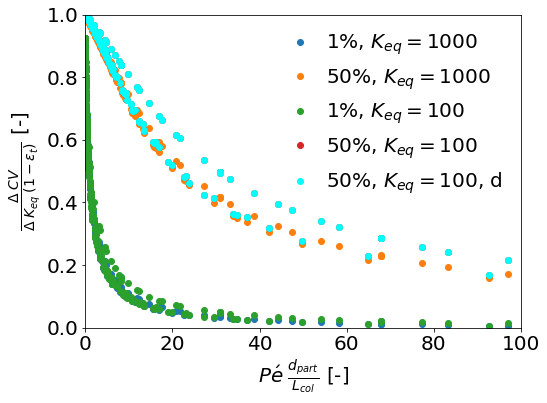

In [39]:
fig, ax = explor.instantiate_fig(8, 6)
ax.set_ylabel(r'$\frac{\Delta \; CV}{\Delta \; K_{eq} \; (1 - \epsilon_t)}$ [-]')
ax.set_xlabel(r'$P\'{e} \; \frac{d_{part}}{L_{col}}$ [-]')

ax.plot(df['yam_x'], df['0.01']/(1.0-eps_t), 'o', label=r'1%, $K_{eq}=1000$')
ax.plot(df['yam_x'], df['0.50']/(1.0-eps_t), 'o', label=r'50%, $K_{eq}=1000$')

ax.plot(df_100['yam_x'], df_100['0.01']/(1.0-eps_t), 'o', label=r'1%, $K_{eq}=100$')
ax.plot(df_100['yam_x'], df_100['0.50']/(1.0-eps_t), 'o', label=r'50%, $K_{eq}=100$')
ax.plot(df_100_desc['yam_x'], df_100_desc['0.50']/(1.0-eps_t), 'o', label=r'50%, $K_{eq}=100$, d', color='cyan')

ax.set_xlim(0, 100)
ax.set_ylim(0, 1)
explor.set_layout(fig, ax, legend=True)
# fig.savefig((image_folder / 'Keq_check_updated_discretization_2.png').as_posix(), dpi=300)

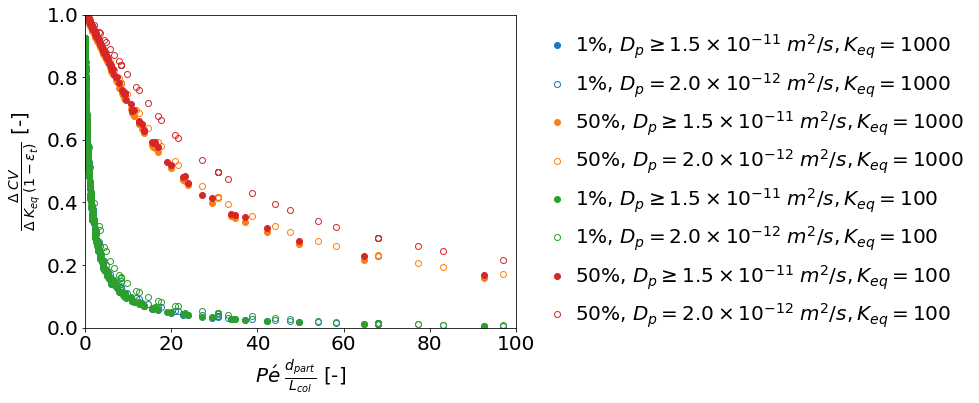

In [216]:
fig, ax = explor.instantiate_fig(14, 6)
ax.set_ylabel(r'$\frac{\Delta \; CV}{\Delta \; K_{eq} \; (1 - \epsilon_t)}$ [-]')
ax.set_xlabel(r'$P\'{e} \; \frac{d_{part}}{L_{col}}$ [-]')

df_smooth = df[df.Dp != 2e-12]
df_high = df[df.Dp == 2e-12]
df_smooth_100 = df_100[df_100.Dp != 2e-12]
df_high_100 = df_100[df_100.Dp == 2e-12]

ax.plot(df_smooth['yam_x'], df_smooth['0.01']/(1.0-eps_t), 'o', 
        label=fr'1%, $D_p \geq {as_si(Dp_vals[1], 1):s} \; m^2/s, K_{{eq}}=1000$')
ax.plot(df_high['yam_x'], df_high['0.01']/(1.0-eps_t), 'o', 
        mfc='none', color=plt.gca().lines[-1].get_color(),
        label=fr'1%, $D_p = {as_si(Dp_vals[0], 1):s} \; m^2/s, K_{{eq}}=1000$')
ax.plot(df_smooth['yam_x'], df_smooth['0.50']/(1.0-eps_t), 'o',
       label=fr'50%, $D_p \geq {as_si(Dp_vals[1], 1):s} \; m^2/s, K_{{eq}}=1000$')
ax.plot(df_high['yam_x'], df_high['0.50']/(1.0-eps_t), 'o', 
        mfc='none', color=plt.gca().lines[-1].get_color(),
       label=fr'50%, $D_p = {as_si(Dp_vals[0], 1):s} \; m^2/s, K_{{eq}}=1000$')

ax.plot(df_smooth_100['yam_x'], df_smooth_100['0.01']/(1.0-eps_t), 'o', 
        label=fr'1%, $D_p \geq {as_si(Dp_vals[1], 1):s} \; m^2/s, K_{{eq}}=100$')
ax.plot(df_high_100['yam_x'], df_high_100['0.01']/(1.0-eps_t), 'o', 
        mfc='none', color=plt.gca().lines[-1].get_color(),
        label=fr'1%, $D_p = {as_si(Dp_vals[0], 1):s} \; m^2/s, K_{{eq}}=100$')
ax.plot(df_smooth_100['yam_x'], df_smooth_100['0.50']/(1.0-eps_t), 'o',
       label=fr'50%, $D_p \geq {as_si(Dp_vals[1], 1):s} \; m^2/s, K_{{eq}}=100$')
ax.plot(df_high_100['yam_x'], df_high_100['0.50']/(1.0-eps_t), 'o', 
        mfc='none', color=plt.gca().lines[-1].get_color(),
       label=fr'50%, $D_p = {as_si(Dp_vals[0], 1):s} \; m^2/s, K_{{eq}}=100$')


ax.set_xlim(0, 100)
ax.set_ylim(0, 1)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', handlelength=0.2, frameon=False)

explor.set_layout(fig, ax)
# fig.savefig((image_folder / 'Keq_check_yam_x_Dp_distinction.png').as_posix(), dpi=300)

# Check that the delta values are accurate
Since I'm just using one Keq above to estimate slope, given an intercept at eps_c
Why do the low Dp deviate?

In [284]:
x_vals = []
slope_vals = []

for fVolum in fVolum_vals:
    for Dp in np.linspace(2.0e-12, 4.0e-11, 4):
        for d_part in d_part_vals:
            for l_col in l_col_vals:
                df_temp_1000 = df[(df.fVolum==fVolum) & (df.Dp==Dp) & (df.d_part==d_part) & (df.l_col==l_col)].copy()
                df_temp_1000.reset_index(inplace=True)
                df_temp_100 = df_100[(df_100.fVolum==fVolum) & (df_100.Dp==Dp) & (df_100.d_part==d_part) & (df_100.l_col==l_col)].copy()
                df_temp_100.reset_index(inplace=True)
                
                assert df_temp_1000.at[0, 'yam_x'] == df_temp_100.at[0, 'yam_x']
                x_vals.append(df_temp_1000.at[0, 'yam_x'])
                
                cv1000 = eps_c + df_temp_1000.at[0, 'keq'] * df_temp_1000.at[0, '0.50']
                cv100 = eps_c + df_temp_100.at[0, 'keq'] * df_temp_100.at[0, '0.50']
                slope = (cv1000 - cv100)/(df_temp_1000.at[0, 'keq'] - df_temp_100.at[0, 'keq'])
                slope_vals.append(slope)

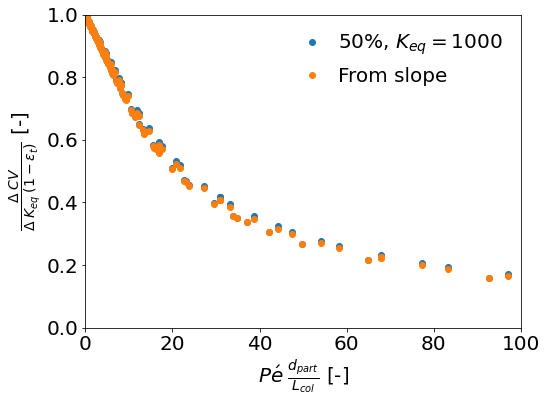

In [291]:
fig, ax = explor.instantiate_fig(8, 6)
ax.set_ylabel(r'$\frac{\Delta \; CV}{\Delta \; K_{eq} \; (1 - \epsilon_t)}$ [-]')
ax.set_xlabel(r'$P\'{e} \; \frac{d_{part}}{L_{col}}$ [-]')

ax.plot(df['yam_x'], df['0.50']/(1.0-eps_t), 'o', label=r'50%, $K_{eq}=1000$')
ax.plot(x_vals, np.array(slope_vals)/(1.0-eps_t), 'o', label=r'From slope')

ax.set_xlim(0, 100)
ax.set_ylim(0, 1)
explor.set_layout(fig, ax, legend=True)
fig.savefig((image_folder / 'Check_slope_with_assumed_intercept.png').as_posix(), dpi=300)

# Plot the data

In [73]:
results_folder = Path().absolute() / 'sim_results_relevant_variable'
if not os.path.exists( results_folder.as_posix() ):
    os.makedirs( results_folder.as_posix() )

In [74]:
def get_sim_data_2(results_folder, file_name):               
    c_load, c_out, t, fVolum, Dp, d_part, l_col =\
    explor.get_sim_results_more_general(results_folder, file_name)

    d_col = 0.5e-2
    area_col = np.pi/4 * d_col**2
    v_col = area_col * l_col
    norm_c = c_out/c_load
   
    df_results = pd.DataFrame(np.array([t, c_out/c_load]).transpose(), columns=['time_s', 'c_normal'])
    df_results['CV'] = fVolum*df_results['time_s']/v_col

    x_val = fVolum*d_part**2/(Dp*l_col)/(eps_c * area_col)
    
    return (x_val, df_results)

In [69]:
x_vals = {}

for fVolum in fVolum_vals:
    for Dp in np.linspace(1.46666667e-11, 4.0e-11, 3):
        for d_part in d_part_vals:
            for l_col in l_col_vals:
                x_val = fVolum*d_part**2/(Dp*l_col)/(eps_c * area_col)
                x_vals[x_val] = (fVolum, Dp, d_part, l_col)
                
vals = list(x_vals.keys())
vals.sort()

In [74]:
dfs = {}
for i, x in enumerate(vals):
    if x > 0.01 and x < 50 and i%20 == 0:
        (fVolum, Dp, d_part, l_col) = x_vals[x]
        file_name = f'Q_{fVolum:.1e}_Dp_{Dp:.1e}_dpart_{d_part:.1e}_lcol_{l_col:.1e}.h5'
        (x_val, df) = get_sim_data_2(results_folder, file_name)
        assert x_val - x < 0.0001
        dfs[x_val] = df
        
keys = list(dfs.keys())
keys.sort()

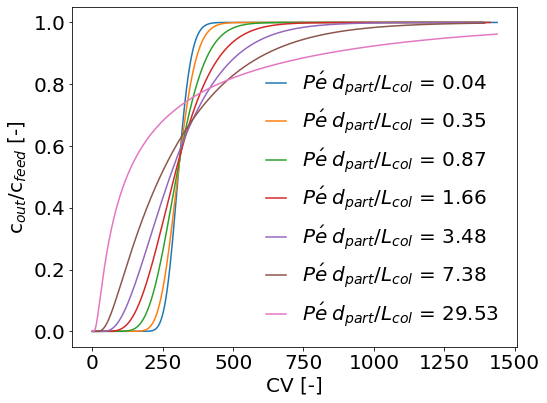

In [77]:
fig, ax = explor.instantiate_fig(8, 6)
ax.set_xlabel('CV [-]')
ax.set_ylabel(r'c$_{out}$/c$_{feed}$ [-]')

for key in keys:
    df = dfs[key]
    ax.plot(df.CV, df.c_normal, label=fr'$P\'{{e}} \; d_{{part}}/L_{{col}}$ = {key:.2f}')

explor.set_layout(fig, ax, legend=True)
fig.savefig((image_folder / 'grouped_breakthrough_smooth_Dp.png').as_posix(), dpi=300)

In [89]:
x_vals = {}
Dp = 2.0e-12

for fVolum in fVolum_vals:
    for d_part in d_part_vals:
        for l_col in l_col_vals:
            x_val = fVolum*d_part**2/(Dp*l_col)/(eps_c * area_col)
            x_vals[x_val] = (fVolum, Dp, d_part, l_col)
                
vals = list(x_vals.keys())
vals.sort()

dfs = {}
for i, x in enumerate(vals):
    if x > 0.01 and x < 50 and i%6 == 0:
        (fVolum, Dp, d_part, l_col) = x_vals[x]
        file_name = f'Q_{fVolum:.1e}_Dp_{Dp:.1e}_dpart_{d_part:.1e}_lcol_{l_col:.1e}.h5'
        (x_val, df) = get_sim_data_2(results_folder, file_name)
        assert x_val - x < 0.0001
        dfs[x_val] = df
        
keys = list(dfs.keys())
keys.sort()

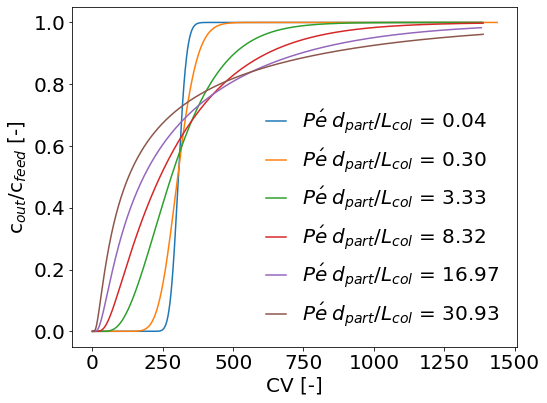

In [90]:
fig, ax = explor.instantiate_fig(8, 6)
ax.set_xlabel('CV [-]')
ax.set_ylabel(r'c$_{out}$/c$_{feed}$ [-]')

for key in keys:
    df = dfs[key]
    ax.plot(df.CV, df.c_normal, label=fr'$P\'{{e}} \; d_{{part}}/L_{{col}}$ = {key:.2f}')

explor.set_layout(fig, ax, legend=True)
fig.savefig((image_folder / 'grouped_breakthrough_low_Dp.png').as_posix(), dpi=300)

# Attempt at head-to-head comparison
What is happening at low Dp?

Note:  **I would need to re-run simulations with identical F* to make a true comparison**

In [63]:
x_vals_low = list(df[df.Dp == 2.0e-12].yam_x)
x_vals_oth = list(df[df.Dp != 2.0e-12].yam_x)

x_vals_low.sort()
x_vals_oth.sort()

x_vals_low = np.array(x_vals_low)
x_vals_oth = np.array(x_vals_oth)

pairs = []
for i in x_vals_low:
    idx = (np.abs(x_vals_oth - i)).argmin()
    pairs.append([i, x_vals_oth[idx], abs(i-x_vals_oth[idx])/i])
    
pairs = np.array(pairs)
pairs = pairs[pairs[:,2].argsort()]


In [76]:
dfs_lo, dfs_hi = {}, {}

for i, j in zip(pairs[:5,0], pairs[:5,1]):
    df_lo = df[df.yam_x == i]
    df_hi = df[df.yam_x == j]
    assert len(df_lo) == 1
    assert len(df_hi) == 1
    
    fVolum_lo = df_lo['fVolum'].values[0]
    Dp_lo = df_lo['Dp'].values[0]
    d_part_lo = df_lo['d_part'].values[0]
    l_col_lo = df_lo['l_col'].values[0]
    file_name = f'Q_{fVolum_lo:.1e}_Dp_{Dp_lo:.1e}_dpart_{d_part_lo:.1e}_lcol_{l_col_lo:.1e}.h5'
    x_val, df_results = get_sim_data_2(results_folder, file_name)
    dfs_lo[x_val] = df_results
    
    fVolum_hi = df_hi['fVolum'].values[0]
    Dp_hi = df_hi['Dp'].values[0]
    d_part_hi = df_hi['d_part'].values[0]
    l_col_hi = df_hi['l_col'].values[0]
    file_name = f'Q_{fVolum_hi:.1e}_Dp_{Dp_hi:.1e}_dpart_{d_part_hi:.1e}_lcol_{l_col_hi:.1e}.h5'
    x_val, df_results = get_sim_data_2(results_folder, file_name)
    dfs_hi[x_val] = df_results
    
keys_lo = list(dfs_lo.keys())
keys_lo.sort()

keys_hi = list(dfs_hi.keys())
keys_hi.sort()

In [78]:
keys_lo

[0.06061808094905311,
 0.16973062665734867,
 0.4243265666433717,
 12.373362683320714,
 16.973062665734865]

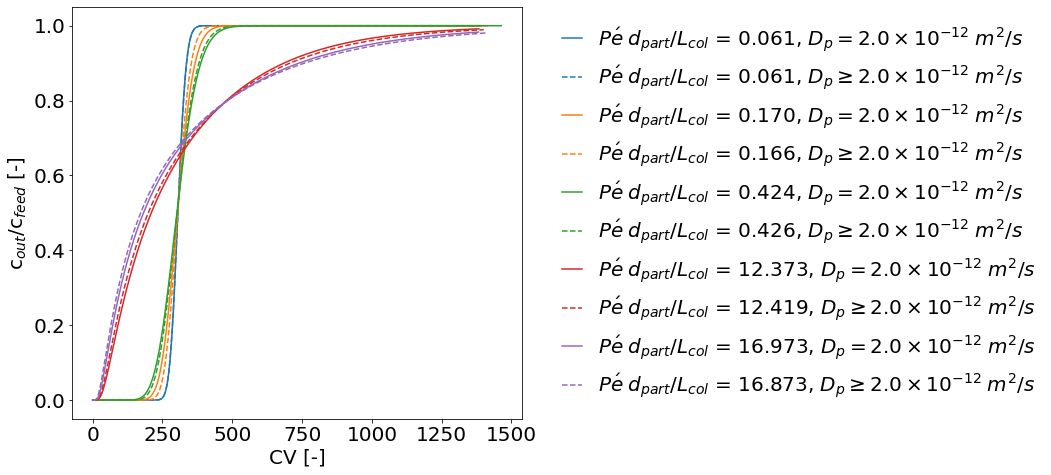

In [99]:
fig, ax = explor.instantiate_fig(15, 7)
ax.set_xlabel('CV [-]')
ax.set_ylabel(r'c$_{out}$/c$_{feed}$ [-]')
    
for i, j in zip(keys_lo, keys_hi):
    df_lo = dfs_lo[i]
    df_hi = dfs_hi[j]
    ax.plot(df_lo.CV, df_lo.c_normal, 
            label=fr'$P\'{{e}} \; d_{{part}}/L_{{col}}$ = {i:.3f}, $D_p = {as_si(Dp_vals[0], 1):s} \; m^2/s$')
    ax.plot(df_hi.CV, df_hi.c_normal, '--',
            label=fr'$P\'{{e}} \; d_{{part}}/L_{{col}}$ = {j:.3f}, $D_p \geq {as_si(Dp_vals[0], 1):s} \; m^2/s$',
            color=plt.gca().lines[-1].get_color())

ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', handlelength=1, frameon=False)
explor.set_layout(fig, ax)
fig.savefig((image_folder / 'grouped_breakthrough_comparison_for_Dp.png').as_posix(), dpi=300)

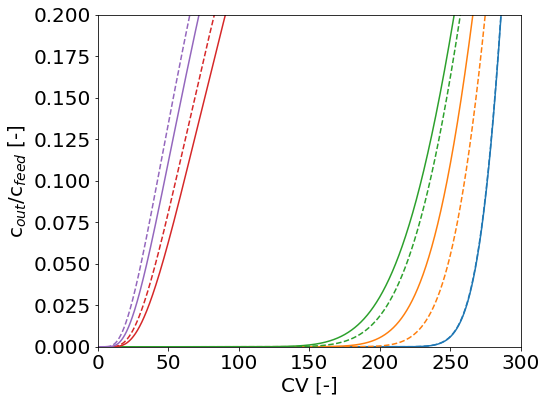

In [95]:
fig, ax = explor.instantiate_fig(8, 6)
ax.set_xlabel('CV [-]')
ax.set_ylabel(r'c$_{out}$/c$_{feed}$ [-]')
    
for i, j in zip(keys_lo, keys_hi):
    df_lo = dfs_lo[i]
    df_hi = dfs_hi[j]
    ax.plot(df_lo.CV, df_lo.c_normal)
    ax.plot(df_hi.CV, df_hi.c_normal, '--',
            color=plt.gca().lines[-1].get_color())

ax.set_xlim(0,300)
ax.set_ylim(0, 0.2)
explor.set_layout(fig, ax)
fig.savefig((image_folder / 'grouped_breakthrough_comparison_for_Dp_zoomed.png').as_posix(), dpi=300)